**USING RESNET18 WITH AND WITHOUT PRETRAINED WEIGHTS**

**LOADING THE SSL MODEL AND TRAINING A CLASSIFIER ON TOP OF IT**

Reference 1: https://pytorch.org/tutorials/beginner/introyt/trainingyt.html

Reference 2: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [1]:
%load_ext pycodestyle_magic

In [2]:
%pycodestyle_on

***

***

# Imports

## Libraries and modules

In [3]:
import utils

import os

import torch
import torchvision

from torchinfo import summary

import lightly
from lightly.models.modules.heads import SimSiamPredictionHead
from lightly.models.modules.heads import SimSiamProjectionHead
import copy

import matplotlib.pyplot as plt
import numpy as np
import math
import random

# Training checks.
import time

# Showing images in the notebook.
from IPython.display import Image
from IPython.core.display import HTML

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

## Settings

In [4]:
# Training on GPU.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Hyperparamenters.
expt = utils.Experiment(epochs=200)

## Reproducibility

In [5]:
# Seed torch and numpy.
os.environ['PYTHONHASHSEED'] = str(expt.seed)
torch.manual_seed(expt.seed)
np.random.seed(expt.seed)
random.seed(expt.seed)

# Enable CUDNN deterministic mode.
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Issues a warning if it is not met.
torch.use_deterministic_algorithms(True)

In [6]:
# For dataloaders.
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


g = torch.Generator()
g.manual_seed(expt.seed)

In [7]:
# Enable deterministic behavior using external GPU.
# %env CUBLAS_WORKSPACE_CONFIG=:4096:8
# %env CUBLAS_WORKSPACE_CONFIG=:16:8
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'

***

***

# Loading dataset

In [8]:
ratio = (.01, .01, .98)
# ratio = (.7, .1, .2)

data_dir_target = f'datasets/Sentinel2GlobalLULC_full' \
                  f'-ratio={ratio}' \
                  f'-seed={expt.seed}'

print(data_dir_target)

if ratio == (.01, .01, .98):

    mean_train = [0.3341, 0.3395, 0.3636]
    std_train = [0.2904, 0.2328, 0.2091]

    mean_val = [0.3357, 0.3382, 0.3616]
    std_val = [0.2942, 0.2330, 0.2069]

    mean_test = [0.3327, 0.3372, 0.3603]
    std_test = [0.2976, 0.2376, 0.2115]

elif ratio == (.7, .1, .2):

    mean_train = [0.3329, 0.3373, 0.3603]
    std_train = [0.2978, 0.2377, 0.2115]

    mean_val = [0.3318, 0.3363, 0.3597]
    std_val = [0.2962, 0.2364, 0.2104]

    mean_test = [0.3328, 0.3375, 0.3605]
    std_test = [0.2974, 0.2378, 0.2118]

datasets/Sentinel2GlobalLULC_full-ratio=(0.01, 0.01, 0.98)-seed=42


## Custom tranforms (w/o normalization)

Define the augmentations for self-supervised learning.

In [9]:
# Data augmentations for the train dataset.
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((expt.input_size, expt.input_size)),
    torchvision.transforms.RandomResizedCrop(224, scale=(0.2, 1.)),
    torchvision.transforms.RandomApply([
            torchvision.transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
        ], p=0.8),  # not strengthened
    torchvision.transforms.RandomGrayscale(p=0.2),
    # torchvision.transforms.RandomApply([
    #     simsiam.loader.GaussianBlur([.1, 2.])
    # ], p=0.5),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean_train, std_train)
])

# Data augmentations for the val and test datasets.
val_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((expt.input_size, expt.input_size)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean_val, std_val)
])

# Data augmentations for the val and test datasets.
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((expt.input_size, expt.input_size)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean_test, std_test)
])

## ImageFolder

In [10]:
# Loading the three datasets.
train_data = torchvision.datasets.ImageFolder(data_dir_target + '/train/',
                                              transform=train_transform)

val_data = torchvision.datasets.ImageFolder(data_dir_target + '/val/',
                                            transform=val_transform)

test_data = torchvision.datasets.ImageFolder(data_dir_target + '/test/',
                                             transform=test_transform)

In [11]:
# Get classes and number.
class_names = train_data.classes
print(class_names)

['01_BarrenLands___jpeg', '02_MossAndLichen_jpeg', '03_Grasslands____jpeg', '04_ShrublandOpen_jpeg', '05_SrublandClose_jpeg', '06_ForestsOpDeBr_jpeg', '07_ForestsClDeBr_jpeg', '08_ForestsDeDeBr_jpeg', '09_ForestsOpDeNe_jpeg', '10_ForestsClDeNe_jpeg', '11_ForestsDeDeNe_jpeg', '12_ForestsOpEvBr_jpeg', '13_ForestsClEvBr_jpeg', '14_ForestsDeEvBr_jpeg', '15_ForestsOpEvNe_jpeg', '16_ForestsClEvNe_jpeg', '17_ForestsDeEvNe_jpeg', '18_WetlandMangro_jpeg', '19_WetlandSwamps_jpeg', '20_WetlandMarshl_jpeg', '21_WaterBodyMari_jpeg', '22_WaterBodyCont_jpeg', '23_PermanentSnow_jpeg', '24_CropSeasWater_jpeg', '25_CropCereaIrri_jpeg', '26_CropCereaRain_jpeg', '27_CropBroadIrri_jpeg', '28_CropBroadRain_jpeg', '29_UrbanBlUpArea_jpeg']


## PyTorch dataloaders

In [12]:
# Dataloader for training.
dataloader_train = torch.utils.data.DataLoader(
    train_data,
    batch_size=expt.batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=expt.num_workers,
    worker_init_fn=seed_worker,
    generator=g
)

# Dataloader for validating.
dataloader_val = torch.utils.data.DataLoader(
    val_data,
    batch_size=expt.batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=expt.num_workers,
    worker_init_fn=seed_worker,
    generator=g
)

# Dataloader for embedding.
dataloader_test = torch.utils.data.DataLoader(
    test_data,
    batch_size=expt.batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=expt.num_workers,
    worker_init_fn=seed_worker,
    generator=g
)

## Check the balance and size of the dataset

In [13]:
# Check samples per class in train dataset.
print(np.unique(train_data.targets, return_counts=True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]), array([140,  46,  88, 140, 119,  44,  13, 140, 104,  63,  28,   5,  12,
       140,  39,  38, 139,   4,   4,  42, 140, 140, 140,  20,   8,  10,
         3,   4, 125]))


In [14]:
# Check samples per class in test dataset.
print(np.unique(test_data.targets, return_counts=True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]), array([13720,  4564,  8693, 13720, 11699,  4349,  1322, 13720, 10230,
        6254,  2824,   557,  1234, 13720,  3836,  3796, 13713,   408,
         479,  4121, 13720, 13720, 13720,  1964,   826,  1000,   347,
         405, 12340]))


In [15]:
# Print some stats from the train dataset.
print(len(train_data.targets))

# Print some stats from the train dataloader.
print('N samples in train dataset: ' + str(len(dataloader_train.sampler)))
print('N samples in train dataset: ' + str(len(dataloader_train.dataset)))
print('N batches in train dataset: ' + str(len(dataloader_train)))

1938
N samples in train dataset: 1938
N samples in train dataset: 1938
N batches in train dataset: 15


In [16]:
# Print some stats from the val dataset.
print(len(val_data.targets))

# Print some stats from the val dataloader.
print('N samples in val dataset: ' + str(len(dataloader_val.dataset)))
print('N batches in val dataset: ' + str(len(dataloader_val)))

1938
N samples in val dataset: 1938
N batches in val dataset: 16


In [17]:
# Print some stats from the test dataset.
print(len(test_data.targets))

# Print some stats from the test dataloader.
print('N samples in test dataset: ' + str(len(dataloader_test.dataset)))
print('N batches in test dataset: ' + str(len(dataloader_test)))

191001
N samples in test dataset: 191001
N batches in test dataset: 1493


## See some samples (pytorch dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([128, 3, 224, 224])
Labels batch shape: torch.Size([128])


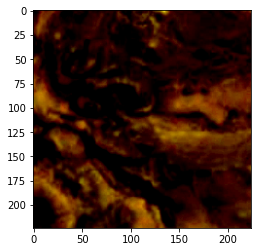

Label: 04_ShrublandOpen_jpeg


In [18]:
# Display image and label.
train_features, train_labels = next(iter(dataloader_train))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(torch.permute(img, (1, 2, 0)), cmap="gray")
plt.show()
print(f"Label: {class_names[label]}")

***

***

# Training loop

In [19]:
# Training function.
def train_model(model, criterion, optimizer, device,
                epochs=10, save_best_model=False):
    """
    Main training function.

    """

    print(f"Using {device} device")

    # Avoiding "CUDA out of memory" in PyTorch.
    torch.cuda.empty_cache()

    # Loss history.
    loss_values = {}
    loss_values['train'] = []
    loss_values['val'] = []
    total_time = 0

    # Saving best model's weights.
    best_model_val_wts = copy.deepcopy(model.state_dict())
    lowest_val_loss = 10000

    # Model to GPU if available.
    model.to(device)

    # Iterating over the epochs.
    for epoch in range(epochs):

        # Initialize training loss.
        running_train_loss = 0.0

        # Start timer.
        since = time.time()

        for i, data in enumerate(dataloader_train):

            # Get the inputs; data is a list of [inputs, labels].
            inputs, labels = data[0].to(device), data[1].to(device)

            # Enable training.
            model.train()

            # Zero the parameter gradients.
            optimizer.zero_grad()

            # Forward: make predictions.
            outputs = model(inputs)

            # Compute the loss and its gradients.
            loss = criterion(outputs, labels)
            loss.backward()

            # Averaged loss across all training examples * batch_size.
            running_train_loss += loss.item() * inputs.size(0)

            if i % 200 == 199:
                print(f'T[{epoch + 1}, {i + 1:5d}] | '
                      f'Running loss: '
                      f'{running_train_loss/(i*inputs.size(0)):.4f}')

            # Adjust learning weights.
            optimizer.step()

        # Loss averaged across all training examples for the current epoch.
        epoch_train_loss = running_train_loss / len(dataloader_train.sampler)

        # Change model to evaluation mode.
        model.eval()

        # Initialize validating loss.
        running_val_loss = 0.0
        with torch.no_grad():
            for j, vdata in enumerate(dataloader_val):

                # Get the inputs; data is a list of [inputs, labels].
                vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)

                # Forward: make predictions.
                voutputs = model(vinputs)

                # Compute the loss (w/o gradients).
                vloss = criterion(voutputs, vlabels)

                # Averaged loss across all validating examples * batch_size.
                running_val_loss += vloss.item() * vinputs.size(0)

                if j % 50 == 49:
                    print(f'V[{epoch + 1}, {j + 1:5d}] | '
                          f'Running loss: '
                          f'{running_val_loss/(j*inputs.size(0)):.4f}')

        # Loss averaged across all validating examples for the current epoch.
        epoch_val_loss = running_val_loss / len(dataloader_val.sampler)

        # Append loss values.
        loss_values['train'].append(epoch_train_loss)
        loss_values['val'].append(epoch_val_loss)

        # Deep copy the weights of the model.
        save_weights = epoch_val_loss < lowest_val_loss
        if save_weights:
            lowest_val_loss = epoch_val_loss
            best_model_train_loss = epoch_train_loss
            best_model_val_wts = copy.deepcopy(model.state_dict())

        # End timer.
        time_elapsed = time.time() - since
        total_time += time_elapsed

        # Show stats.
        print(f'Epoch: {epoch} | '
              f'Train loss: {epoch_train_loss:.4f} | '
              f'Val loss: {epoch_val_loss:.4f} | '
              f'Elapsed: {time_elapsed // 60:.0f}m '
              f'{time_elapsed % 60:.0f}s | '
              f'Save weights: {save_weights}')

    print(f'\nTraining completed in {total_time // 60:.0f}m '
          f'{total_time % 60:.0f}s')

    # Load best model weights.
    model.load_state_dict(best_model_val_wts)

    if save_best_model:

        # Move to CPU before saving it.
        model.to('cpu')

        # Filename with stats.
        save_path = f'pytorch_models/resnet18' \
                    f'-losses={best_model_train_loss:.2f}' \
                    f'_{lowest_val_loss:.2f}' \
                    f'-time={datetime.now():%Y_%m_%d-%H_%M_%S}'

        # Save this pretrained model (recommended approach).
        torch.save(model.state_dict(), save_path)

        print('Model successfuly saved')

        # Move back to the GPU.
        model.to(device)

    return model, loss_values

In [20]:
def plot_losses(loss_history, title='', save_fig=False):
    """
    Function for plotting the training and validation losses

    """

    fig = plt.figure(figsize=(10, 5))
    plt.plot(loss_history['train'], label='Train')
    plt.plot(loss_history['val'], label='Validation')
    plt.xlabel('Epoch', labelpad=15)
    plt.ylabel('Loss', labelpad=15)
    plt.title(title)
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.gcf().subplots_adjust(left=0.15)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

    if save_fig:
        fig.savefig('plt_loss_values.pdf', bbox_inches='tight')

In [21]:
def evaluation_on_test(model, device):
    """
    Function to evaluate the performance
    of the model on the test dataset.

    """

    # Avoiding "CUDA out of memory" in PyTorch.
    torch.cuda.empty_cache()

    correct = 0
    total = 0

    # Since we're not training, we don't need to calculate
    # the gradients for our outputs with torch.no_grad():
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(dataloader_test):

            # Dataset.
            inputs, labels = data[0].to(device), data[1].to(device)

            # Calculate outputs by running images through the network.
            outputs = model(inputs)

            # The class with the highest energy is what we
            # choose as prediction.
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Progress bar.
            if i % 50 == 49:
                print(f'Progress: {100 * i // len(dataloader_test)}%',
                      end='\r',
                      flush=True)

    print(f'Accuracy of the network on the {total} '
          f'test images: {100 * correct // total}%')

***

***

# ResNet18 from scrath

## Definition and hyperparameters

In [22]:
# Model: resnet with random weights.
model = torchvision.models.resnet18(weights=None)

## Adjust final layer

Type: linear not softmax for the moment.

In [23]:
# Check old final layer.
print(model.fc)

# Get the number of input features to the layer.
num_ftrs = model.fc.in_features
print(num_ftrs)

# Adjust the final layer to the current number of classes.
model.fc = torch.nn.Linear(num_ftrs, len(class_names))

# Check new final layer.
print(model.fc)

# Freezing all the network except the final layer.
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

# Model structure.
summary(
    model,
    input_size=(expt.batch_size, 3, expt.input_size, expt.input_size),
    device=device
)

Linear(in_features=512, out_features=1000, bias=True)
512
Linear(in_features=512, out_features=29, bias=True)


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [128, 29]                 --
├─Conv2d: 1-1                            [128, 64, 112, 112]       (9,408)
├─BatchNorm2d: 1-2                       [128, 64, 112, 112]       (128)
├─ReLU: 1-3                              [128, 64, 112, 112]       --
├─MaxPool2d: 1-4                         [128, 64, 56, 56]         --
├─Sequential: 1-5                        [128, 64, 56, 56]         --
│    └─BasicBlock: 2-1                   [128, 64, 56, 56]         --
│    │    └─Conv2d: 3-1                  [128, 64, 56, 56]         (36,864)
│    │    └─BatchNorm2d: 3-2             [128, 64, 56, 56]         (128)
│    │    └─ReLU: 3-3                    [128, 64, 56, 56]         --
│    │    └─Conv2d: 3-4                  [128, 64, 56, 56]         (36,864)
│    │    └─BatchNorm2d: 3-5             [128, 64, 56, 56]         (128)
│    │    └─ReLU: 3-6                    [128, 64, 56, 56] 

## Loss fcn and optimizer

In [24]:
# Loss function: cross-entropy loss.
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizers: specified in the torch.optim package
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.001)

## Training

Using cuda device
Epoch: 0 | Train loss: 2.8902 | Val loss: 2.8416 | Elapsed: 0m 5s | Save weights: True
Epoch: 1 | Train loss: 2.5191 | Val loss: 2.5465 | Elapsed: 0m 4s | Save weights: True
Epoch: 2 | Train loss: 2.3866 | Val loss: 2.2382 | Elapsed: 0m 4s | Save weights: True
Epoch: 3 | Train loss: 2.2844 | Val loss: 2.0023 | Elapsed: 0m 4s | Save weights: True
Epoch: 4 | Train loss: 2.1937 | Val loss: 1.9041 | Elapsed: 0m 4s | Save weights: True
Epoch: 5 | Train loss: 2.1709 | Val loss: 1.8030 | Elapsed: 0m 4s | Save weights: True
Epoch: 6 | Train loss: 2.1439 | Val loss: 1.7492 | Elapsed: 0m 4s | Save weights: True
Epoch: 7 | Train loss: 2.0885 | Val loss: 1.7185 | Elapsed: 0m 5s | Save weights: True
Epoch: 8 | Train loss: 2.0861 | Val loss: 1.6658 | Elapsed: 0m 4s | Save weights: True
Epoch: 9 | Train loss: 2.0454 | Val loss: 1.6243 | Elapsed: 0m 4s | Save weights: True
Epoch: 10 | Train loss: 2.0218 | Val loss: 1.5972 | Elapsed: 0m 4s | Save weights: True
Epoch: 11 | Train loss: 

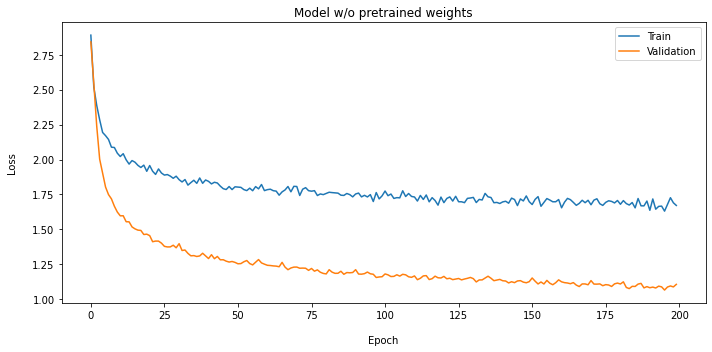

In [25]:
model, loss_history = train_model(
    model,
    loss_fn,
    optimizer,
    device,
    epochs=expt.epochs,
    save_best_model=True
)

plot_losses(loss_history, 'Model w/o pretrained weights')

## Check performance on test dataset

In [26]:
evaluation_on_test(model, device)

Accuracy of the network on the 191001 test images: 70%


## F1-score

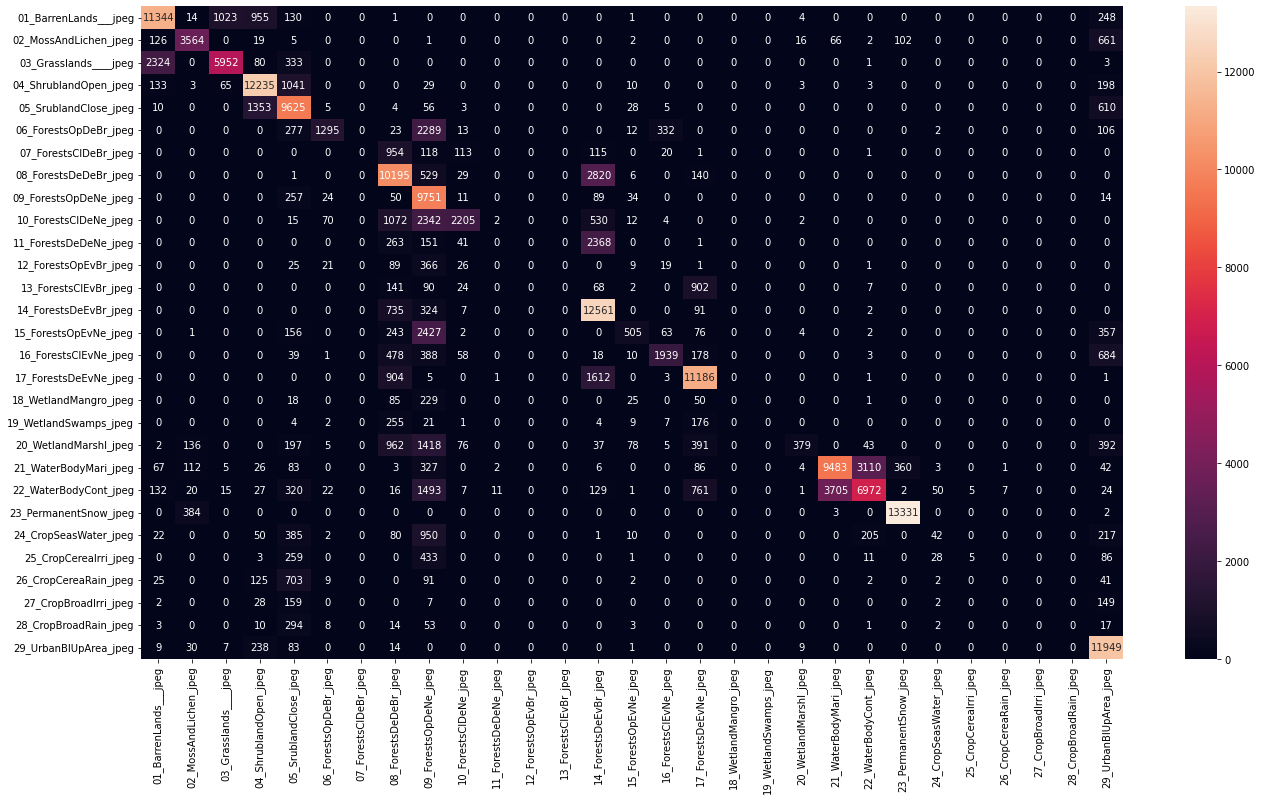

/home/sfandres/Documents/Git/lulc/lulc-venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sfandres/Documents/Git/lulc/lulc-venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sfandres/Documents/Git/lulc/lulc-venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

                       precision    recall  f1-score   support

01_BarrenLands___jpeg       0.83      0.80      0.81     14199
02_MossAndLichen_jpeg       0.78      0.84      0.81      4264
03_Grasslands____jpeg       0.68      0.84      0.76      7067
04_ShrublandOpen_jpeg       0.89      0.81      0.85     15149
05_SrublandClose_jpeg       0.82      0.67      0.74     14409
06_ForestsOpDeBr_jpeg       0.30      0.88      0.45      1464
07_ForestsClDeBr_jpeg       0.00      0.00      0.00         0
08_ForestsDeDeBr_jpeg       0.74      0.61      0.67     16581
09_ForestsOpDeNe_jpeg       0.95      0.41      0.57     23888
10_ForestsClDeNe_jpeg       0.35      0.84      0.50      2616
11_ForestsDeDeNe_jpeg       0.00      0.00      0.00        16
12_ForestsOpEvBr_jpeg       0.00      0.00      0.00         0
13_ForestsClEvBr_jpeg       0.00      0.00      0.00         0
14_ForestsDeEvBr_jpeg       0.92      0.62      0.74     20358
15_ForestsOpEvNe_jpeg       0.13      0.66      0.22  

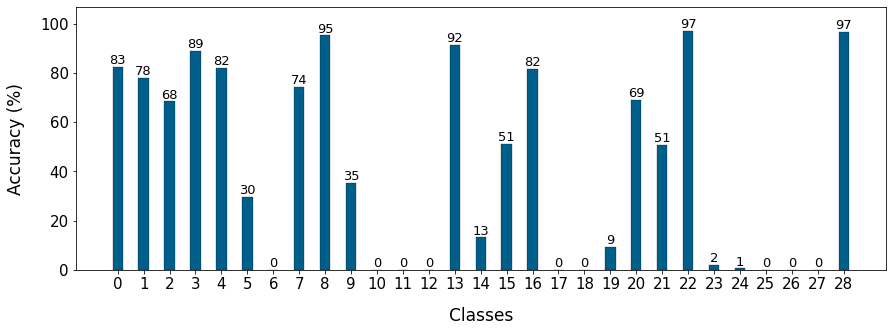

In [27]:
# Confusion matrix
conf_mat, class_accuracy = utils.create_confusion_matrix(
    model,
    dataloader_test,
    device,
    class_names
)

# Bar plot for accuracy values.
utils.simple_bar_plot(range(len(class_names)),
                      class_accuracy,
                      'Classes',
                      'Accuracy (%)',
                      'class_accuracy',
                      fig_size=(15, 5),
                      save=False)

***

***

# ResNet18 with pretrained weights

## Definition and hyperparameters

In [28]:
# Model: resnet with pretrained weights.
del model
model = torchvision.models.resnet18(
    weights=torchvision.models.ResNet18_Weights.DEFAULT
)

## Adjust final layer

In [29]:
# Check old final layer.
print(model.fc)

# Get the number of input features to the layer.
num_ftrs = model.fc.in_features
print(num_ftrs)

# Adjust the final layer to the current number of classes.
model.fc = torch.nn.Linear(num_ftrs, len(class_names))

# Parameters of newly constructed modules
# have requires_grad=True by default.
# Check new final layer.
print(model.fc)

# Freezing all the network except the final layer.
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

# Model structure.
summary(
    model,
    input_size=(expt.batch_size, 3, expt.input_size, expt.input_size),
    device=device
)

Linear(in_features=512, out_features=1000, bias=True)
512
Linear(in_features=512, out_features=29, bias=True)


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [128, 29]                 --
├─Conv2d: 1-1                            [128, 64, 112, 112]       (9,408)
├─BatchNorm2d: 1-2                       [128, 64, 112, 112]       (128)
├─ReLU: 1-3                              [128, 64, 112, 112]       --
├─MaxPool2d: 1-4                         [128, 64, 56, 56]         --
├─Sequential: 1-5                        [128, 64, 56, 56]         --
│    └─BasicBlock: 2-1                   [128, 64, 56, 56]         --
│    │    └─Conv2d: 3-1                  [128, 64, 56, 56]         (36,864)
│    │    └─BatchNorm2d: 3-2             [128, 64, 56, 56]         (128)
│    │    └─ReLU: 3-3                    [128, 64, 56, 56]         --
│    │    └─Conv2d: 3-4                  [128, 64, 56, 56]         (36,864)
│    │    └─BatchNorm2d: 3-5             [128, 64, 56, 56]         (128)
│    │    └─ReLU: 3-6                    [128, 64, 56, 56] 

## Loss fcn and optimizer

In [30]:
# Loss function: cross-entropy loss.
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizers: specified in the torch.optim package
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.001)

## Training

Using cuda device
Epoch: 0 | Train loss: 2.6975 | Val loss: 2.4854 | Elapsed: 0m 4s | Save weights: True
Epoch: 1 | Train loss: 1.9901 | Val loss: 1.6930 | Elapsed: 0m 4s | Save weights: True
Epoch: 2 | Train loss: 1.6315 | Val loss: 1.3326 | Elapsed: 0m 4s | Save weights: True
Epoch: 3 | Train loss: 1.4418 | Val loss: 1.1254 | Elapsed: 0m 4s | Save weights: True
Epoch: 4 | Train loss: 1.2991 | Val loss: 1.0230 | Elapsed: 0m 4s | Save weights: True
Epoch: 5 | Train loss: 1.1869 | Val loss: 0.9495 | Elapsed: 0m 4s | Save weights: True
Epoch: 6 | Train loss: 1.1044 | Val loss: 0.8858 | Elapsed: 0m 4s | Save weights: True
Epoch: 7 | Train loss: 1.0785 | Val loss: 0.8259 | Elapsed: 0m 5s | Save weights: True
Epoch: 8 | Train loss: 1.0384 | Val loss: 0.7972 | Elapsed: 0m 4s | Save weights: True
Epoch: 9 | Train loss: 0.9926 | Val loss: 0.7572 | Elapsed: 0m 4s | Save weights: True
Epoch: 10 | Train loss: 0.9672 | Val loss: 0.7296 | Elapsed: 0m 4s | Save weights: True
Epoch: 11 | Train loss: 

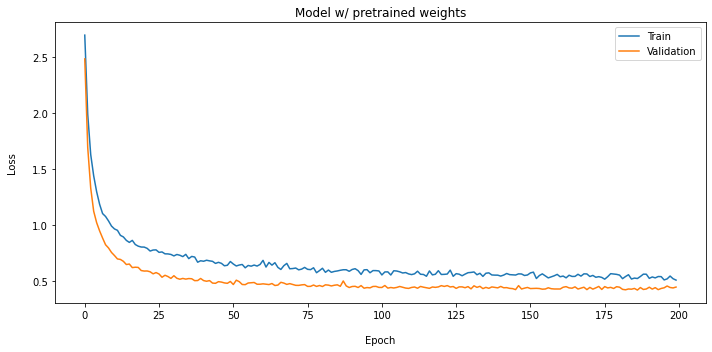

In [31]:
model, loss_history = train_model(
    model,
    loss_fn,
    optimizer,
    device,
    epochs=expt.epochs,
    save_best_model=True
)

plot_losses(loss_history, 'Model w/ pretrained weights')

## Check performance on test dataset

In [32]:
evaluation_on_test(model, device)

Accuracy of the network on the 191001 test images: 85%


## F1-score

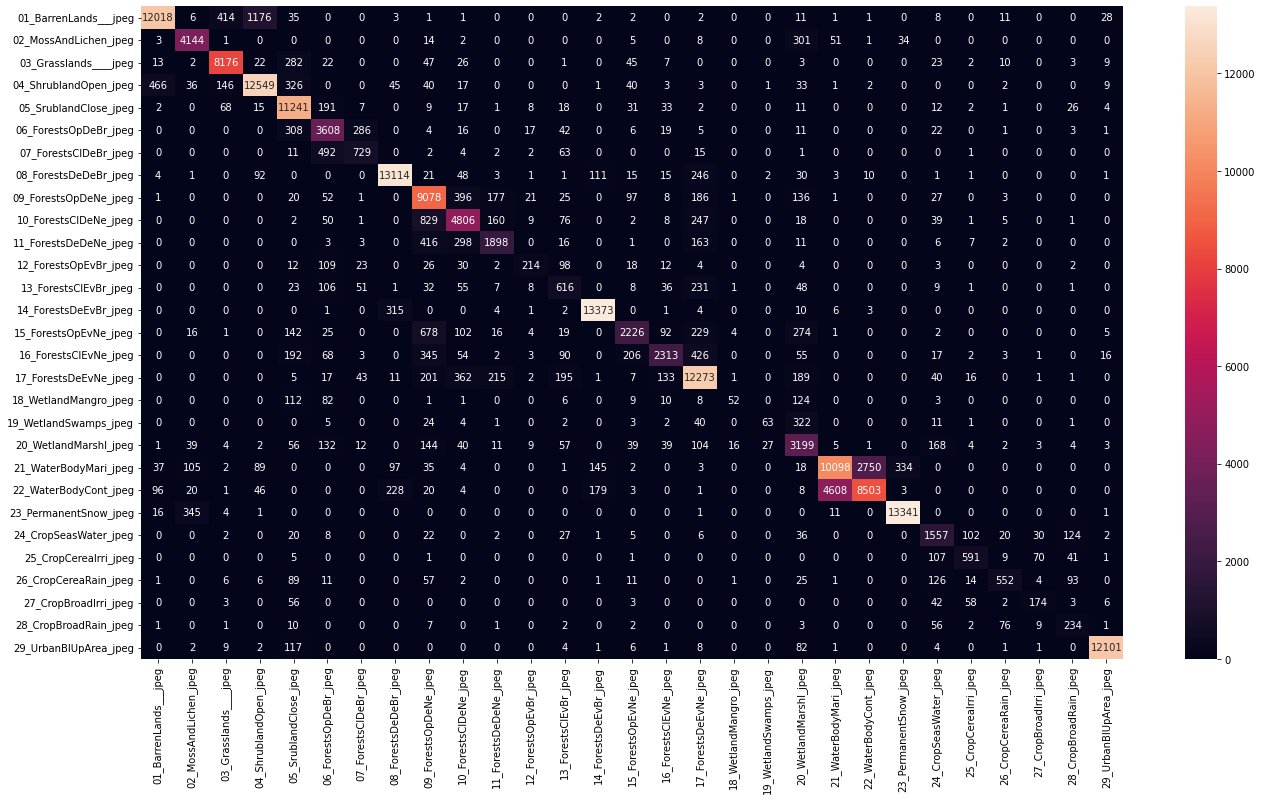

                       precision    recall  f1-score   support

01_BarrenLands___jpeg       0.88      0.95      0.91     12659
02_MossAndLichen_jpeg       0.91      0.88      0.89      4716
03_Grasslands____jpeg       0.94      0.93      0.93      8838
04_ShrublandOpen_jpeg       0.91      0.90      0.91     14000
05_SrublandClose_jpeg       0.96      0.86      0.91     13064
06_ForestsOpDeBr_jpeg       0.83      0.72      0.77      4982
07_ForestsClDeBr_jpeg       0.55      0.63      0.59      1159
08_ForestsDeDeBr_jpeg       0.96      0.95      0.95     13814
09_ForestsOpDeNe_jpeg       0.89      0.75      0.81     12054
10_ForestsClDeNe_jpeg       0.77      0.76      0.77      6289
11_ForestsDeDeNe_jpeg       0.67      0.76      0.71      2502
12_ForestsOpEvBr_jpeg       0.38      0.72      0.50       299
13_ForestsClEvBr_jpeg       0.50      0.45      0.47      1361
14_ForestsDeEvBr_jpeg       0.97      0.97      0.97     13815
15_ForestsOpEvNe_jpeg       0.58      0.80      0.67  

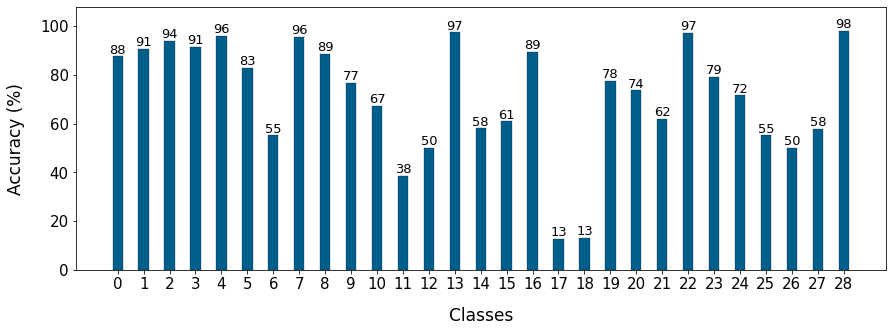

In [33]:
# Confusion matrix
conf_mat, class_accuracy = utils.create_confusion_matrix(
    model,
    dataloader_test,
    device,
    class_names
)

# Bar plot for accuracy values.
utils.simple_bar_plot(range(len(class_names)),
                      class_accuracy,
                      'Classes',
                      'Accuracy (%)',
                      'class_accuracy',
                      fig_size=(15, 5),
                      save=False)

***

***

# SSL model

## Loading

In [34]:
# State model class.
resnet18 = torchvision.models.resnet18(weights=None)

# Only backbone (w/o final fc layer).
pt_backbone = torch.nn.Sequential(*list(resnet18.children())[:-1])

In [35]:
# List of trained models.
model_list = []
for root, dirs, files in os.walk('pytorch_models/simsiam/'):
    for i, filename in enumerate(sorted(files, reverse=True)):
        model_list.append(root + filename)
        print(f'{i:02}: {filename}')

00: simsiam_backbone_resnet18-epoch=029-loss=-0.9765-coll=0.2451(0)_0.0334(0.044194)-time=2022_11_29_18_14_31
01: simsiam_backbone_resnet18-epoch=028-loss=-0.9662-coll=0.2353(0)_0.0338(0.044194)-time=2022_11_29_18_06_23
02: simsiam_backbone_resnet18-epoch=027-loss=-0.9668-coll=0.2061(0)_0.0351(0.044194)-time=2022_11_29_17_58_16
03: simsiam_backbone_resnet18-epoch=026-loss=-0.9655-coll=0.2142(0)_0.0347(0.044194)-time=2022_11_29_17_50_07
04: simsiam_backbone_resnet18-epoch=025-loss=-0.9633-coll=0.2255(0)_0.0342(0.044194)-time=2022_11_29_17_42_00
05: simsiam_backbone_resnet18-epoch=024-loss=-0.9611-coll=0.2236(0)_0.0343(0.044194)-time=2022_11_29_17_33_53
06: simsiam_backbone_resnet18-epoch=023-loss=-0.9628-coll=0.2208(0)_0.0344(0.044194)-time=2022_11_29_17_25_48
07: simsiam_backbone_resnet18-epoch=022-loss=-0.9612-coll=0.1862(0)_0.0360(0.044194)-time=2022_11_29_17_17_41
08: simsiam_backbone_resnet18-epoch=021-loss=-0.9549-coll=0.1840(0)_0.0361(0.044194)-time=2022_11_29_17_09_33
09: simsia

In [36]:
# Loading model.
idx = 1
print(model_list[idx])
pt_backbone.load_state_dict(torch.load(model_list[idx]))

pytorch_models/simsiam/simsiam_backbone_resnet18-epoch=028-loss=-0.9662-coll=0.2353(0)_0.0338(0.044194)-time=2022_11_29_18_06_23


<All keys matched successfully>

In [37]:
# Check if the model is loaded on GPU.
next(pt_backbone.parameters()).is_cuda

False

## Checking the weights

In [38]:
# First convolutional layer weights.
# print(backbone)
print(pt_backbone[0])
print(pt_backbone[0].weight[63])

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
tensor([[[-0.0178,  0.0087,  0.0034, -0.0035, -0.0241, -0.0120,  0.0153],
         [ 0.0040,  0.0137, -0.0131, -0.0064, -0.0207,  0.0041,  0.0024],
         [ 0.0184,  0.0110,  0.0080, -0.0065, -0.0054, -0.0268, -0.0099],
         [ 0.0413, -0.0014,  0.0184,  0.0212,  0.0079, -0.0003, -0.0329],
         [ 0.0251,  0.0403,  0.0252,  0.0296,  0.0104,  0.0202, -0.0031],
         [ 0.0326,  0.0227,  0.0436,  0.0458,  0.0346,  0.0123,  0.0039],
         [ 0.0196,  0.0207,  0.0325,  0.0468, -0.0013,  0.0107,  0.0314]],

        [[-0.0009, -0.0239, -0.0100, -0.0003, -0.0230,  0.0060, -0.0246],
         [-0.0236,  0.0051,  0.0049, -0.0136,  0.0234, -0.0088, -0.0096],
         [ 0.0197,  0.0078, -0.0298, -0.0172, -0.0082, -0.0332, -0.0178],
         [ 0.0147,  0.0236, -0.0145, -0.0010,  0.0214,  0.0311,  0.0165],
         [ 0.0315,  0.0327,  0.0552,  0.0400,  0.0489,  0.0129,  0.0186],
         [ 0.0197,  0.0231,  0.02

## Adding a final linear layer

In [39]:
# Adding a linear layer on top of the model (linear classifier).
model_ssl = torch.nn.Sequential(
    pt_backbone,
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=512, out_features=len(class_names), bias=True),
    # torch.nn.Softmax(dim=1)
)

# Freezing all the network except the final layer.
for param in model_ssl.parameters():
    param.requires_grad = False
# for param in model_ssl[0][7].parameters():
#     param.requires_grad = True
for param in model_ssl[2].parameters():
    param.requires_grad = True

# Model structure.
summary(
    model_ssl,
    input_size=(expt.batch_size, 3, expt.input_size, expt.input_size),
    device=device
)

Layer (type:depth-idx)                        Output Shape              Param #
Sequential                                    [128, 29]                 --
├─Sequential: 1-1                             [128, 512, 1, 1]          --
│    └─Conv2d: 2-1                            [128, 64, 112, 112]       (9,408)
│    └─BatchNorm2d: 2-2                       [128, 64, 112, 112]       (128)
│    └─ReLU: 2-3                              [128, 64, 112, 112]       --
│    └─MaxPool2d: 2-4                         [128, 64, 56, 56]         --
│    └─Sequential: 2-5                        [128, 64, 56, 56]         --
│    │    └─BasicBlock: 3-1                   [128, 64, 56, 56]         (73,984)
│    │    └─BasicBlock: 3-2                   [128, 64, 56, 56]         (73,984)
│    └─Sequential: 2-6                        [128, 128, 28, 28]        --
│    │    └─BasicBlock: 3-3                   [128, 128, 28, 28]        (230,144)
│    │    └─BasicBlock: 3-4                   [128, 128, 28, 28]    

## Loss fcn and optimizer

In [40]:
# Loss function: cross-entropy loss.
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizers: specified in the torch.optim package
optimizer = torch.optim.Adam(model_ssl.parameters(),
                             lr=0.01)

## Training

Using cuda device
Epoch: 0 | Train loss: 1.5786 | Val loss: 0.9509 | Elapsed: 0m 4s | Save weights: True
Epoch: 1 | Train loss: 0.9878 | Val loss: 0.8086 | Elapsed: 0m 4s | Save weights: True
Epoch: 2 | Train loss: 0.9089 | Val loss: 0.7693 | Elapsed: 0m 4s | Save weights: True
Epoch: 3 | Train loss: 0.8852 | Val loss: 0.7234 | Elapsed: 0m 4s | Save weights: True
Epoch: 4 | Train loss: 0.8446 | Val loss: 0.7265 | Elapsed: 0m 5s | Save weights: False
Epoch: 5 | Train loss: 0.8439 | Val loss: 0.7637 | Elapsed: 0m 4s | Save weights: False
Epoch: 6 | Train loss: 0.8182 | Val loss: 0.7361 | Elapsed: 0m 4s | Save weights: False
Epoch: 7 | Train loss: 0.8381 | Val loss: 0.7176 | Elapsed: 0m 4s | Save weights: True
Epoch: 8 | Train loss: 0.7856 | Val loss: 0.6693 | Elapsed: 0m 5s | Save weights: True
Epoch: 9 | Train loss: 0.7848 | Val loss: 0.7081 | Elapsed: 0m 4s | Save weights: False
Epoch: 10 | Train loss: 0.7684 | Val loss: 0.6655 | Elapsed: 0m 4s | Save weights: True
Epoch: 11 | Train lo

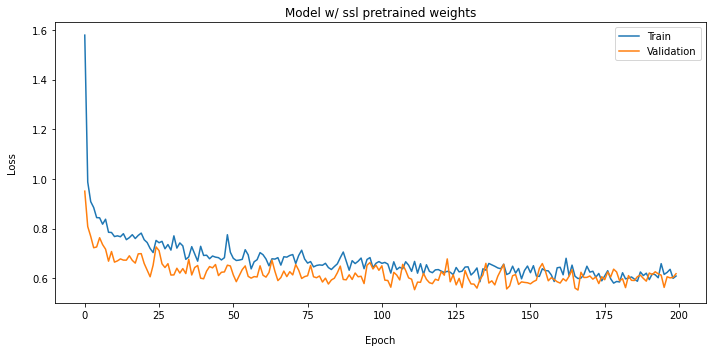

In [41]:
model_ssl, loss_history = train_model(
    model_ssl,
    loss_fn,
    optimizer,
    device,
    epochs=expt.epochs,
    save_best_model=True
)

plot_losses(loss_history, 'Model w/ ssl pretrained weights')

## Checking the weights after training

They should have remained the same (frozen) except for the final layer.

In [42]:
# First convolutional layer weights.
# print(backbone)
print(pt_backbone[0])
print(pt_backbone[0].weight[63])

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
tensor([[[-0.0178,  0.0087,  0.0034, -0.0035, -0.0241, -0.0120,  0.0153],
         [ 0.0040,  0.0137, -0.0131, -0.0064, -0.0207,  0.0041,  0.0024],
         [ 0.0184,  0.0110,  0.0080, -0.0065, -0.0054, -0.0268, -0.0099],
         [ 0.0413, -0.0014,  0.0184,  0.0212,  0.0079, -0.0003, -0.0329],
         [ 0.0251,  0.0403,  0.0252,  0.0296,  0.0104,  0.0202, -0.0031],
         [ 0.0326,  0.0227,  0.0436,  0.0458,  0.0346,  0.0123,  0.0039],
         [ 0.0196,  0.0207,  0.0325,  0.0468, -0.0013,  0.0107,  0.0314]],

        [[-0.0009, -0.0239, -0.0100, -0.0003, -0.0230,  0.0060, -0.0246],
         [-0.0236,  0.0051,  0.0049, -0.0136,  0.0234, -0.0088, -0.0096],
         [ 0.0197,  0.0078, -0.0298, -0.0172, -0.0082, -0.0332, -0.0178],
         [ 0.0147,  0.0236, -0.0145, -0.0010,  0.0214,  0.0311,  0.0165],
         [ 0.0315,  0.0327,  0.0552,  0.0400,  0.0489,  0.0129,  0.0186],
         [ 0.0197,  0.0231,  0.02

## Check performance on test dataset

In [43]:
evaluation_on_test(model_ssl, device)

Accuracy of the network on the 191001 test images: 81%


## F1-score

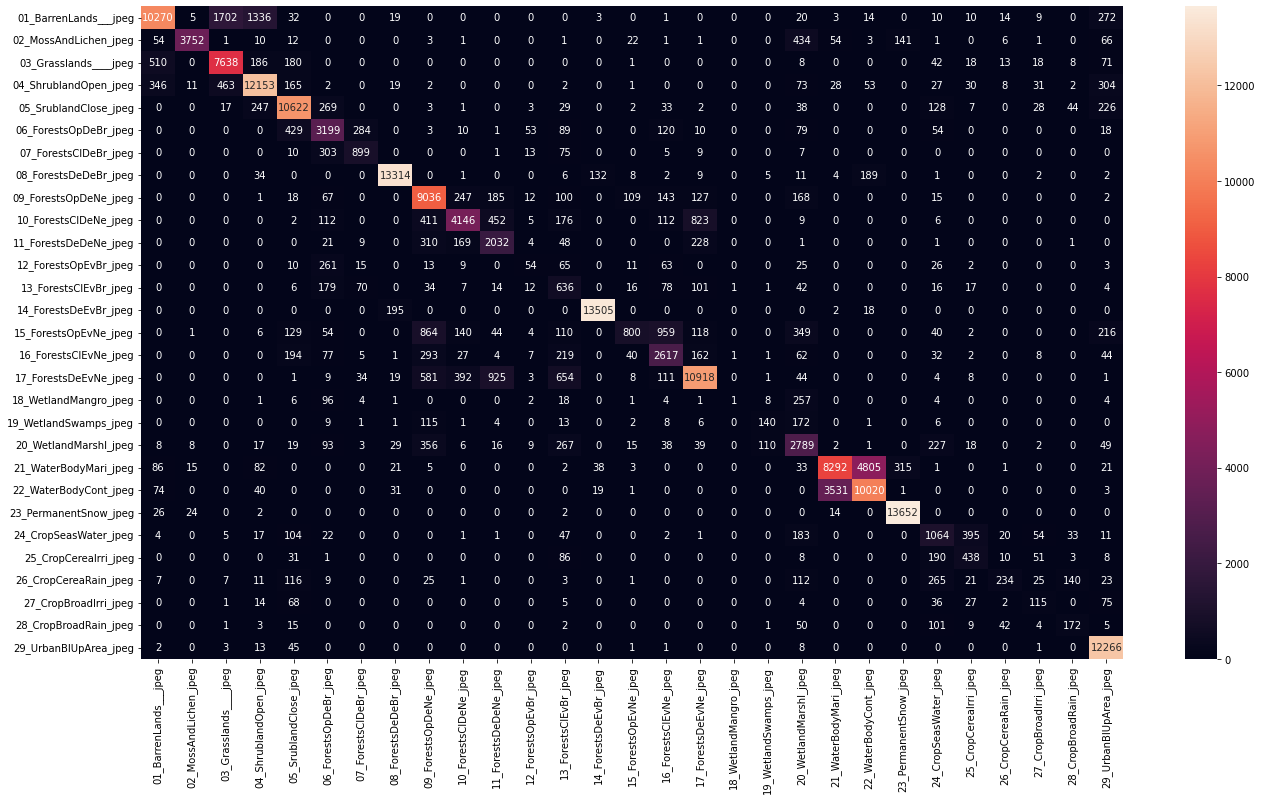

                       precision    recall  f1-score   support

01_BarrenLands___jpeg       0.75      0.90      0.82     11387
02_MossAndLichen_jpeg       0.82      0.98      0.90      3816
03_Grasslands____jpeg       0.88      0.78      0.82      9838
04_ShrublandOpen_jpeg       0.89      0.86      0.87     14173
05_SrublandClose_jpeg       0.91      0.87      0.89     12214
06_ForestsOpDeBr_jpeg       0.74      0.67      0.70      4783
07_ForestsClDeBr_jpeg       0.68      0.68      0.68      1324
08_ForestsDeDeBr_jpeg       0.97      0.98      0.97     13650
09_ForestsOpDeNe_jpeg       0.88      0.75      0.81     12054
10_ForestsClDeNe_jpeg       0.66      0.80      0.73      5159
11_ForestsDeDeNe_jpeg       0.72      0.55      0.62      3679
12_ForestsOpEvBr_jpeg       0.10      0.30      0.15       181
13_ForestsClEvBr_jpeg       0.52      0.24      0.33      2655
14_ForestsDeEvBr_jpeg       0.98      0.99      0.99     13697
15_ForestsOpEvNe_jpeg       0.21      0.77      0.33  

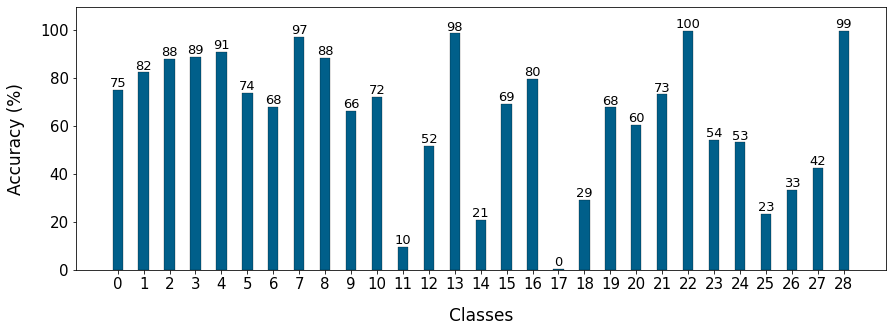

In [44]:
# Confusion matrix
conf_mat, class_accuracy = utils.create_confusion_matrix(
    model_ssl,
    dataloader_test,
    device,
    class_names
)

# Bar plot for accuracy values.
utils.simple_bar_plot(range(len(class_names)),
                      class_accuracy,
                      'Classes',
                      'Accuracy (%)',
                      'class_accuracy',
                      fig_size=(15, 5),
                      save=False)

***

***